This notebook loads the data sent by Carl on 02-dec-2017. 

There are two categories: germline SV and somatic SV. 

The windows are always centered in the BPJ. (In the next version should be centered in any PBJ) 

There are 8 channels per window: 4 from the normal cells and 4 from the tumor cells. 

The 4 channels are: exact matches coverage, regural coverage, number of left clips, number of right clips.

All datasets are balanced. There are 12000 training, 3600 validation, and 3660 test points. 

Then a neural network is trained and saved. The test accuracy of the network is 99.7%. 

## Load dependences and setting output configuration

In [45]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data from npy files

In [46]:
datapath = '/home/sonja/ChannelData_021217/'
germline_cube = np.load(datapath + 'germline_cube_data_file.npy')
somatic_cube = np.load(datapath + 'somatic_cube_data_file.npy')
germline_labels = np.load(datapath + 'germline_label_array_file.npy')
somatic_labels = np.load(datapath + 'somatic_label_array_file.npy')

Eliminate GC content channel, at the moment it is just noise: 

In [47]:
germline_cube_8channels = germline_cube[0:9630,0:8,0:200] 
germline_cube_8channels.shape
somatic_cube_8channels = somatic_cube[0:9630,0:8,0:200]
germline_cube_8channels.shape

(9630, 8, 200)

## Split into training, validation and test datasets

(The numbers should be parameters in the clean version, for now it is OK)

In [48]:
X_train_germline = germline_cube_8channels[0:6000] 
y_train_germline = germline_labels[0:6000]
X_val_germline = germline_cube_8channels[6000:7800]
y_val_germline = germline_labels[6000:7800]
X_test_germline = germline_cube_8channels[7800:9630]
y_test_germline = germline_labels[7800:9630]

In [49]:
X_train_somatic = somatic_cube_8channels[0:6000] 
y_train_somatic = somatic_labels[0:6000]
X_val_somatic = somatic_cube_8channels[6000:7800]
y_val_somatic = somatic_labels[6000:7800]
X_test_somatic = somatic_cube_8channels[7800:9630]
y_test_somatic = somatic_labels[7800:9630]

In [50]:
X_train = np.concatenate((X_train_germline, X_train_somatic), axis =0)
X_val = np.concatenate((X_val_germline, X_val_somatic), axis =0)
X_test = np.concatenate((X_test_germline, X_test_somatic), axis =0)
y_train = np.concatenate((y_train_germline, y_train_somatic), axis =0)
y_val = np.concatenate((y_val_germline, y_val_somatic), axis =0)
y_test = np.concatenate((y_test_germline, y_test_somatic), axis =0)

## Plots of 15 windows from the germline SV category

b'germline'


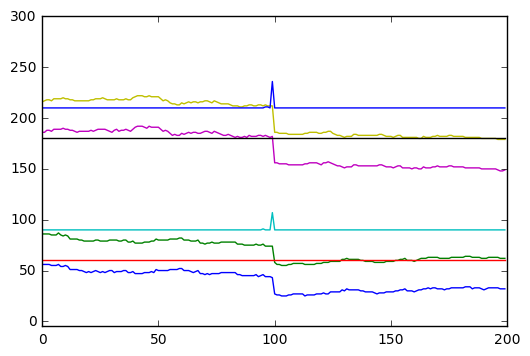

b'germline'


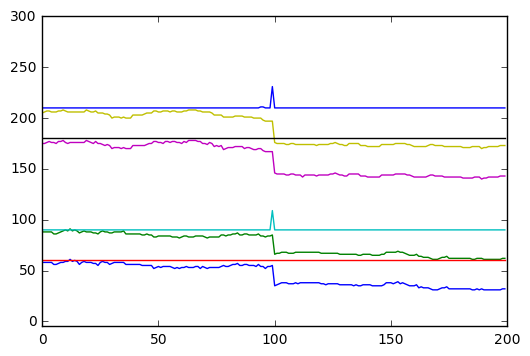

b'germline'


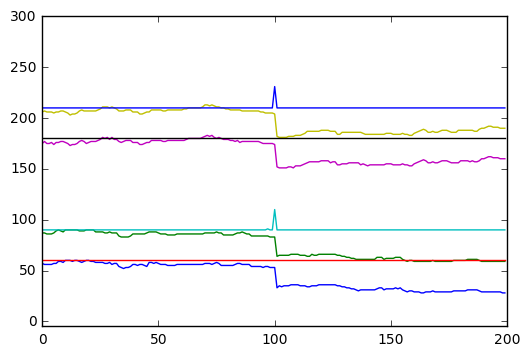

b'germline'


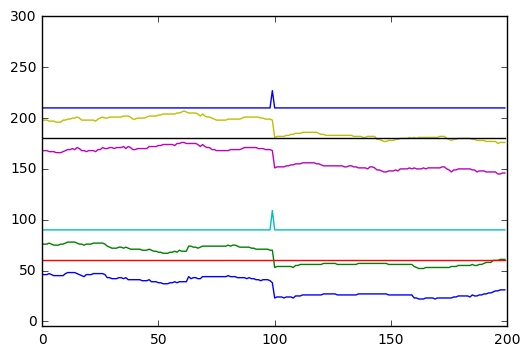

b'germline'


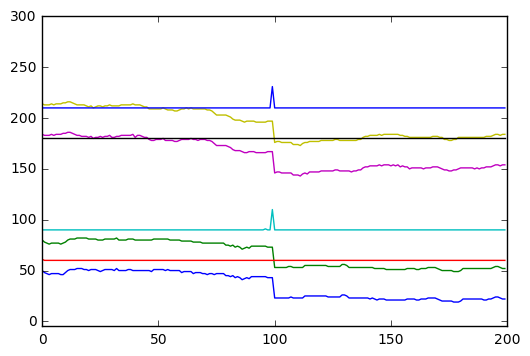

b'germline'


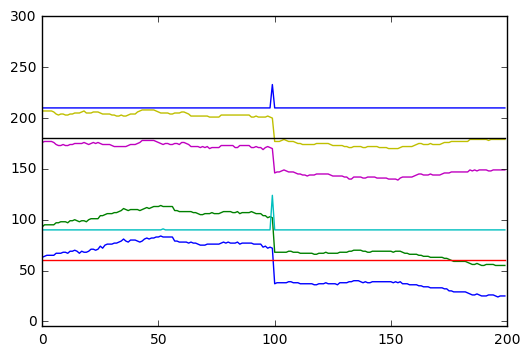

b'germline'


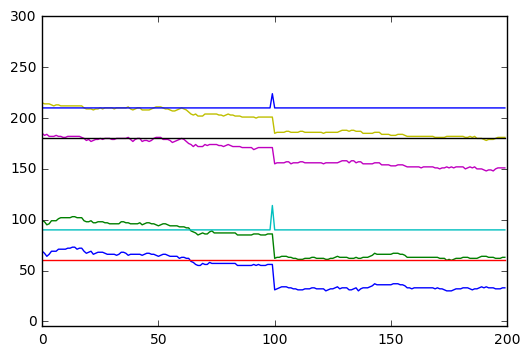

b'germline'


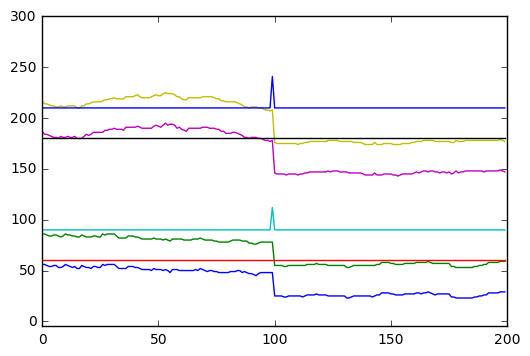

b'germline'


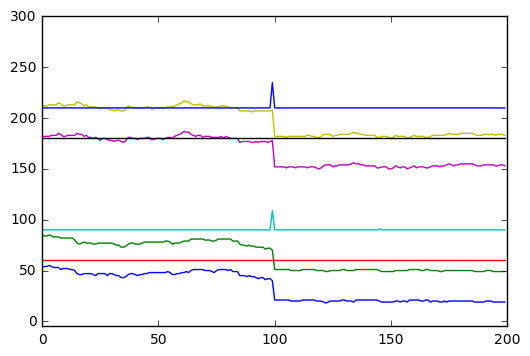

b'germline'


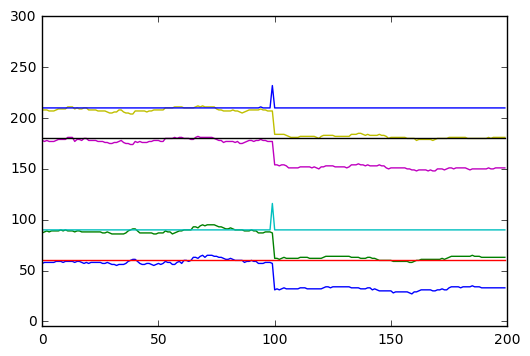

b'germline'


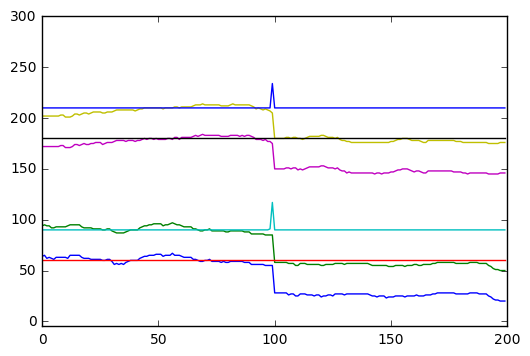

b'germline'


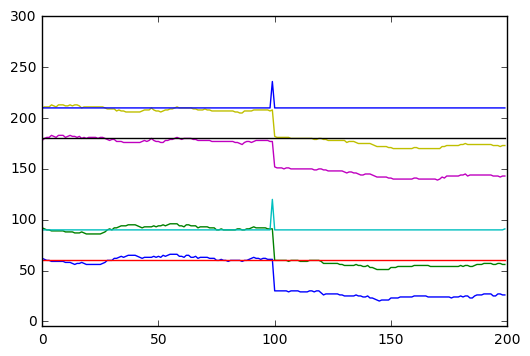

b'germline'


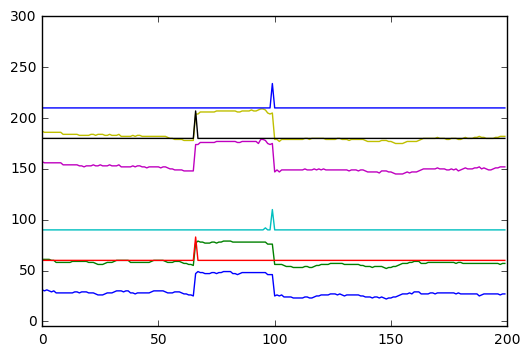

b'germline'


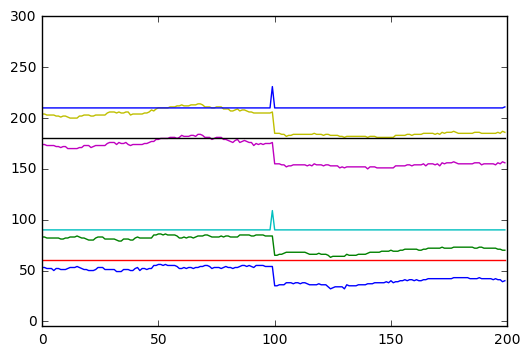

b'germline'


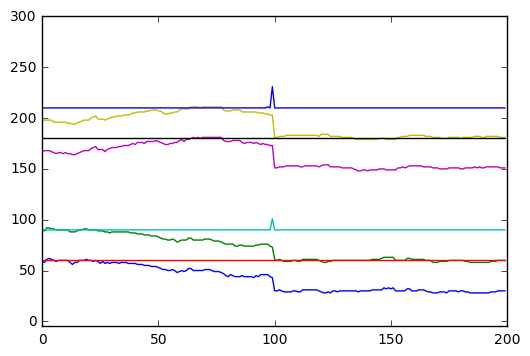

In [54]:
from numpy import *
import math
import matplotlib.pyplot as plt

for i in range (50, 65):
    print(y_train[i])
    for j in range (0, 8):
        Z = [x + 5*j*6 for x in X_train[i][j]] 
        plt.ylim([-5,50*6])
        plt.plot(Z)
    plt.show()

## Plots of 15 windows from the somatic SV category

b'somatic'


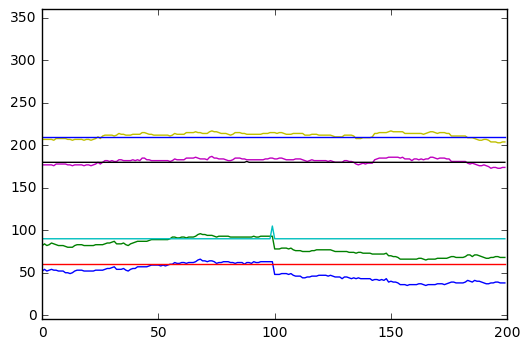

b'somatic'


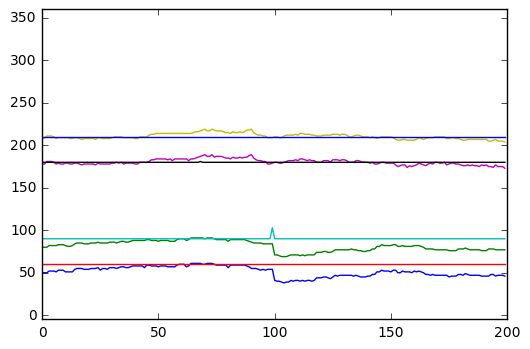

b'somatic'


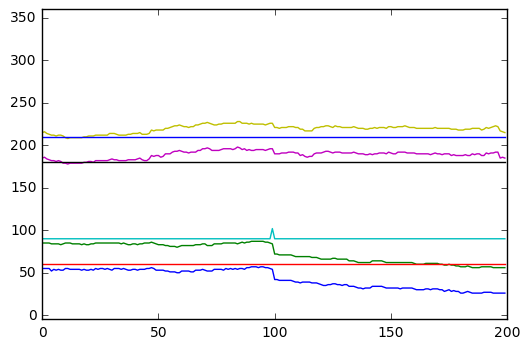

b'somatic'


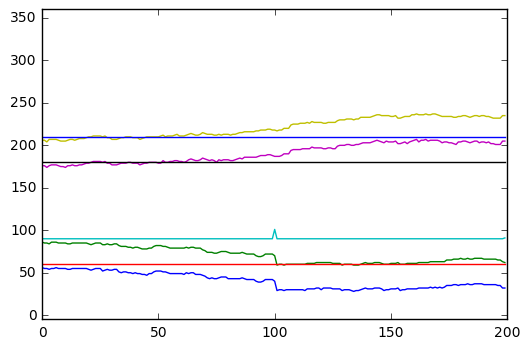

b'somatic'


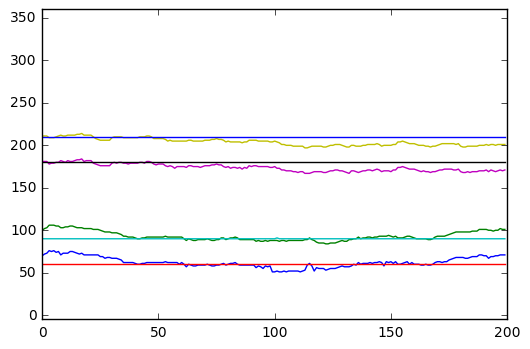

b'somatic'


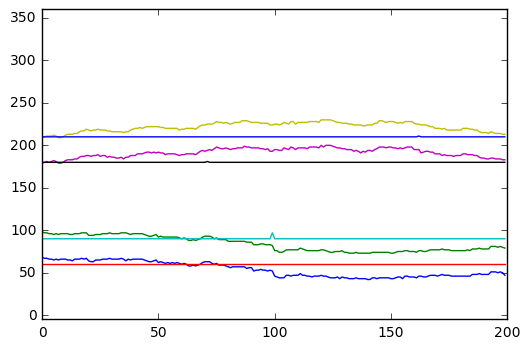

b'somatic'


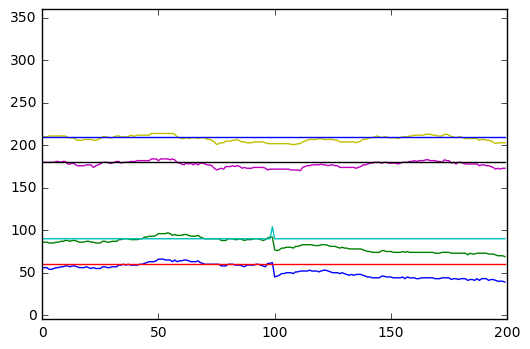

b'somatic'


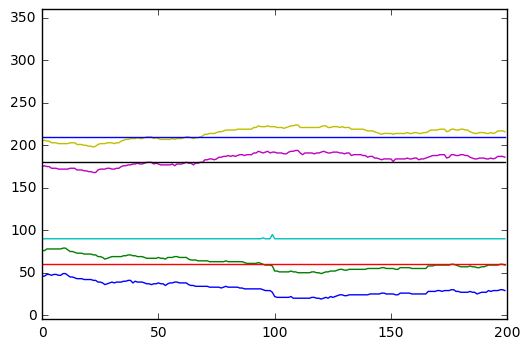

b'somatic'


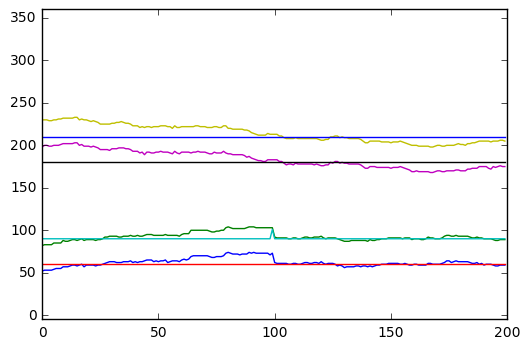

b'somatic'


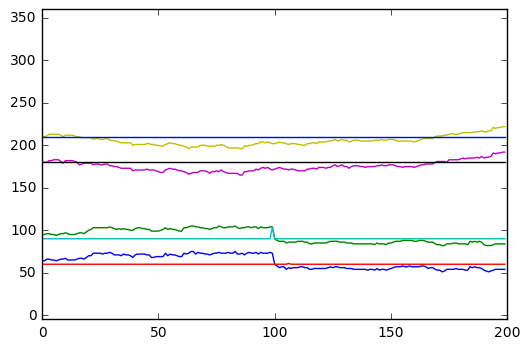

b'somatic'


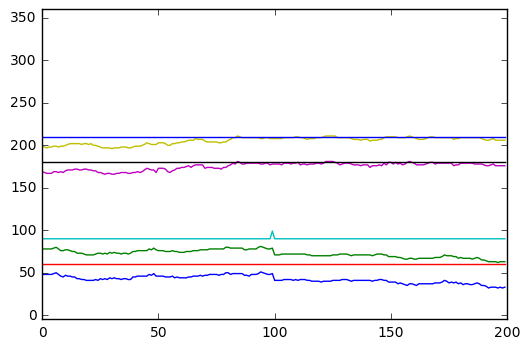

b'somatic'


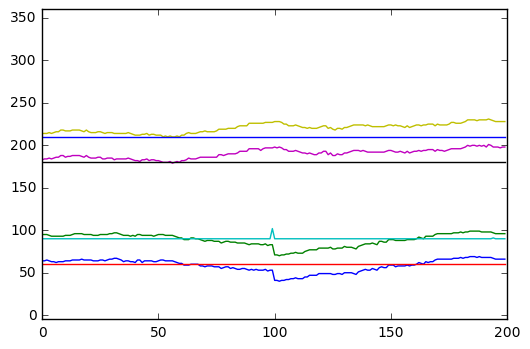

b'somatic'


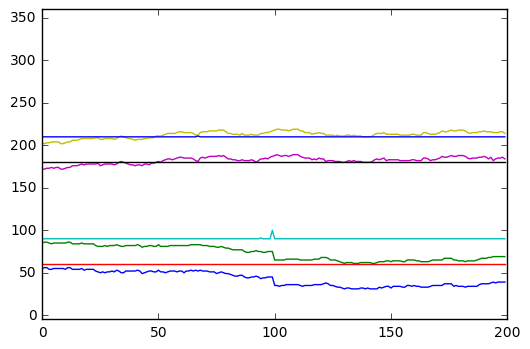

b'somatic'


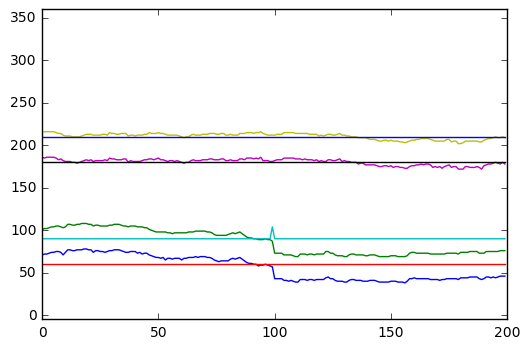

b'somatic'


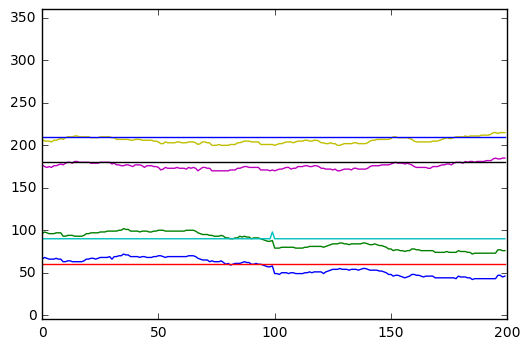

In [58]:
import matplotlib.pyplot as pplt
for i in range (6000, 6015):
    print(y_train[i])
    for j in range (0, 8):
        Z = [x + 5*j*6 for x in X_train[i][j]] 
        pplt.ylim([-5,60*6])
        pplt.plot(Z)
    pplt.show()

   
## Transposes every window in X, to comply to McFly format

In [60]:
def transposeDataset(X):
    image = []
    for i in range (0, len(X -1)):
        tr = X[i].transpose()
        image.append(tr)
    return np.array(image)

image1 = transposeDataset(X_train)
image2 = transposeDataset(X_val)
image3 = transposeDataset(X_test)
X_train = image1
X_val = image2
X_test = image3

n_channels = len(X_train[0][0])
print(len(X_test[0][0]))

8


## Prepare the labels in McFly format

In [ ]:
classlabels = list(set(y_train))
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
print(mapclasses)

y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_val = np.array([mapclasses[c] for c in y_val], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

In [ ]:
y_test_binary

In [ ]:
y_val_binary

In [ ]:
print(len(X_train))
print(len(X_train[0]))
print(len(X_train[0][0]))

## Generate neural networks architectures

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))
from mcfly import modelgen, find_architecture

In [ ]:
np.random.seed = 321
num_classes = y_train_binary.shape[1]

In [ ]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 2,
                                  model_type = 'CNN',
                                  cnn_min_layers=1,
                                  cnn_max_layers=4,
                                  cnn_min_fc_nodes=5, cnn_max_fc_nodes=15,
                                 low_lr=4, high_lr=8)

In [29]:
%%time
for model, params, model_types in models:
    print(params)
    model.summary()

{'learning_rate': 4.34533240505395e-07, 'filters': array([13, 19, 88]), 'regularization_rate': 0.00015697050209298365, 'fc_hidden_nodes': 14}
____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
batchnormalization_11 (BatchNormali(None, 200, 8)      16          batchnormalization_input_3[0][0] 
____________________________________________________________________________________________________
convolution1d_7 (Convolution1D)    (None, 200, 13)     325         batchnormalization_11[0][0]      
____________________________________________________________________________________________________
batchnormalization_12 (BatchNormali(None, 200, 13)     26          convolution1d_7[0][0]            
____________________________________________________________________________________________________
activation_11 (Activation)         (None, 200, 13)

## Train the networks

In [ ]:
%%time
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=5, 
                                                                                  subset_size=12000,
                                                                                  verbose=True)

## Plot training process

Currently run with a very low number of epochs

CPU times: user 776 ms, sys: 0 ns, total: 776 ms
Wall time: 797 ms


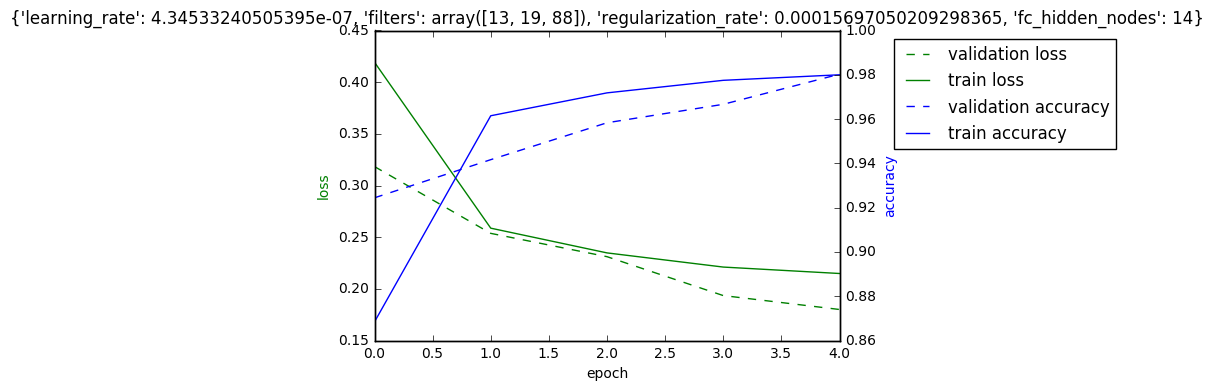

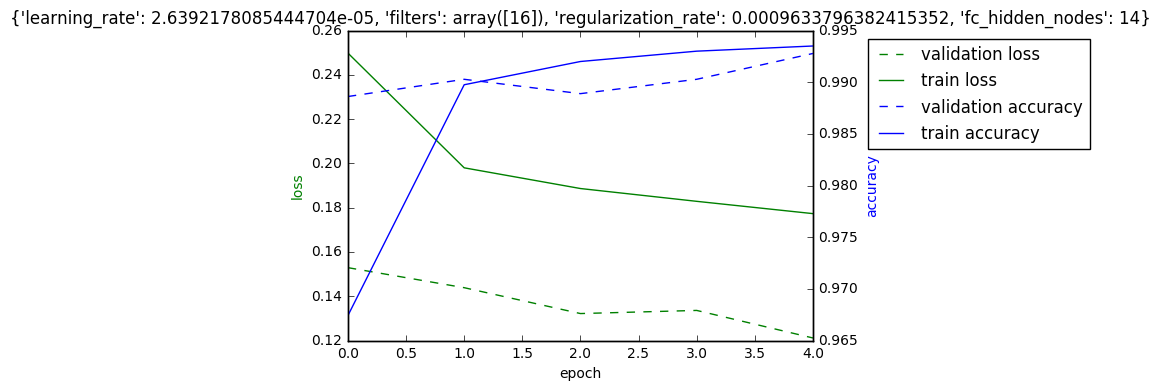

In [30]:
%%time
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)

In [31]:
#%%time
import pandas as pd
results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

,model,train_acc,train_loss,val_acc,val_loss
0,"{'learning_rate': 4.34533240505395e-07, 'filte...",0.9800,0.214839,0.980278,0.180009
1,"{'learning_rate': 2.6392178085444704e-05, 'fil...",0.9935,0.177298,0.992778,0.121141


## Take the best model 

In [ ]:
best_model_index = 1


In [ ]:
best_model_index

In [ ]:
import theano
theano.config.mode

In [ ]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

In [ ]:
best_model_copy = modelgen.generate_CNN_model(X_train.shape, num_classes, best_params['filters'], best_params['fc_hidden_nodes'],
                       best_params['learning_rate'])
best_model_copy = best_model
print(best_model_index, best_model_types, best_params)

## Save the best model

In [ ]:
from mcfly import storage
name_best_model = 'Gtcg_1_5_12_17_99val'

In [ ]:
storage.savemodel(best_model,'/home/sonja/sonja/',name_best_model )

## Reload the best model

In [36]:

from mcfly import storage
model_reloaded = storage.loadmodel('/home/sonja/sonja/',name_best_model )
model_reloaded.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(best_params['learning_rate']), 
                  metrics=['accuracy']) 

## Train the best model (not used for now)

In [ ]:
nr_epochs = 3

datasize = X_train.shape[0]#1000
history = model_reloaded.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary))

In [ ]:
find_architecture.plotTrainingProcess(history)

## Inspect model predictions (not used for now)

In [ ]:
datasize = X_val.shape[0]
best_model_copy.predict_proba(X_val[:datasize,:,:],batch_size=1)

In [ ]:
best_model_copy.summary()

In [ ]:
from keras import backend as K

# with a Sequential model
get_dens_layer_output = K.function([best_model_copy.layers[0].input, K.learning_phase()],
                                  [best_model_copy.layers[0].output])
layer_output = get_dens_layer_output([X_val, 0])[0]

In [ ]:
layer_output.shape

In [ ]:
layer_output.mean(axis=(0,1))

In [ ]:
layer = best_model.layers[0]
for w in layer.get_weights():
    print(w.shape)

## Test on Testset

### Overall accuracy on the test set:

In [63]:
score_test = model_reloaded.evaluate(X_test, y_test_binary, verbose=False)
print('Test loss and accuracy of best model: ' + str(score_test))

Test loss and accuracy of best model: [0.11563290100280053, 0.99699453558426732]


## Re-check the train and validation scores: 

In [ ]:
best_model.get_config()[0]

In [64]:
score_train = model_reloaded.evaluate(X_train, y_train_binary, verbose=False)
print('Train Score of best model: ' + str(score_train))

Train Score of best model: [0.11980280119180679, 0.997]


In [65]:
score_val = model_reloaded.evaluate(X_val, y_val_binary, verbose=False)
print('Val Score of best model: ' + str(score_val))

Val Score of best model: [0.12114071402284834, 0.99277777777777776]
